In [1]:
import numpy as np
import pandas as pd
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

In [2]:
race_df = pd.read_csv("./csv/race-2008.csv", sep=",")
horse_df = pd.read_csv("./csv/horse-2008.csv", sep=",")
for year in range(2009, 2023):
    race_tmp_df = pd.read_csv("./csv/race-"+str(year)+".csv", sep=",", low_memory=False)
    horse_tmp_df = pd.read_csv("./csv/horse-"+str(year)+".csv", sep=",", low_memory=False)
    race_df = pd.concat([race_df, race_tmp_df], axis=0)
    horse_df = pd.concat([horse_df, horse_tmp_df], axis=0)

## 元データの確認

In [3]:
# race_id単位で重複したデータが存在しないか確認
print(len(race_df) == len(race_df['race_id'].unique()))
print(race_df.shape)
race_df.tail(2)

True
(49925, 28)


,race_id,race_round,race_title,race_course,weather,ground_status,time,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3
1726,202209030411,11 R,第63回宝塚記念(G1),芝右2200m,天候 : 晴,芝 : 良,発走 : 15:40\n\n過去の宝塚記念,2022年6月26日,3回阪神4日目,18,3,6,5,10,4,7,420,180,250,240,"2,520","2,060",780,710,840,"3,420","5,150","25,220"
1727,202209030412,12 R,リボン賞,ダ右1200m,天候 : 晴,ダート : 良,発走 : 16:30\n\n過去のリボン賞,2022年6月26日,3回阪神4日目,16,3,5,7,14,8,15,990,290,"1,520",660,"9,570","34,170","6,890","3,370","10,540","52,400","137,920","1,016,060"


In [4]:
# 出走馬数の確認
race_df["total_horse_number"].value_counts()

16    18137
15     5614
14     5083
18     4324
13     3993
12     3809
11     2801
10     2283
9      1612
8       961
17      804
7       351
6       117
5        36
Name: total_horse_number, dtype: int64

In [5]:
print(horse_df.shape)
horse_df.head(2)

(713857, 19)


,race_id,rank,frame_number,horse_number,horse_id,sex_and_age,burden_weight,rider_id,goal_time,goal_time_dif,time_value,half_way_rank,last_time,odds,popular,horse_weight,tame_time,tamer_id,owner_id
0,200806010101,1,1,2,2005102028,牝3,54.0,733,1:13.9,NaN,\n\n**\n\n,1-1,39.2,8.1,4.0,450(-10),\n\n,138,498800
1,200806010101,2,3,5,2005101044,牝3,54.0,663,1:13.9,ハナ,\n\n**\n\n,10-7,38.5,13.4,6.0,482(+2),\n\n,1088,163002


## raceデータの整形

In [6]:
race_df.head(1)

,race_id,race_round,race_title,race_course,weather,ground_status,time,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3
0,200806010101,1 R,3歳未勝利,ダ右1200m,天候 : 曇,ダート : 良,発走 : 09:50,2008年1月5日,1回中山1日目,16,1,2,3,5,2,3,810,260,400,290,"3,480","4,520","1,550",960,"1,560","8,940","10,600",0


### race_id
そのままでOK

In [7]:
# 一応確認
race_df["race_id"].dtypes

dtype('int64')

### race_round
余分な空白とRを取り除く

In [8]:
race_df["race_round"].dtypes

dtype('O')

In [9]:
race_df['race_round'].unique()

array(['1 R', '2 R', '3 R', '4 R', '5 R', '6 R', '7 R', '8 R', '9 R',
       '10 R', '11 R', '12 R'], dtype=object)

In [10]:
race_df['race_round'] = race_df['race_round'].str.strip('R \n')

In [11]:
race_df['race_round'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)

In [12]:
race_df['race_round'] = race_df['race_round'].astype(int)
race_df["race_round"].dtypes

dtype('int32')

### race_title
いらないので削除

In [13]:
# もともとのカラムは不要なので削除
race_df.drop(['race_title'], axis=1, inplace=True)

### race_course
「ダ右1200m」などであれば、ダート・右回り・1200に分割して、それぞれ別のカラムにする。

新たに4つのカラムを追加
- 障害コースか？
- 地面のタイプは何か？
- 右回り・左回り・直線か？
- 距離は？

In [14]:
race_df["race_course"].unique()

array(['ダ右1200m', 'ダ右1800m', '芝右 外1600m', '芝右2000m', '芝右 外1200m',
       'ダ右2500m', '芝右1800m', '障芝 ダート3200m', '芝右 外2200m', '障芝 ダート2880m',
       'ダ右2400m', '芝右2500m', 'ダ右1400m', '芝右 外1800m', '芝右 外3000m',
       '障芝 ダート2930m', '芝右1200m', '芝右1600m', '芝右 外1400m', '芝右 外2400m',
       '障芝 ダート3190m', '芝右1400m', 'ダ右1000m', 'ダ右1700m', '芝右2600m',
       'ダ左1400m', 'ダ左2100m', 'ダ左1600m', '障芝 ダート3000m', '芝左1800m',
       '芝左2400m', 'ダ左1300m', '芝左1400m', '芝左1600m', '障芝 ダート3300m',
       '芝左2000m', '芝左3400m', 'ダ左2400m', 'ダ右1900m', '障芝 ダート3790m',
       '障芝 外3350m', 'ダ左1700m', 'ダ左1000m', '芝左1200m', '芝左2500m', 'ダ左2300m',
       '障芝 ダート3110m', '障芝 ダート2970m', '芝右2200m', 'ダ右2000m', '障芝3900m',
       '芝右3000m', 'ダ右1150m', '芝左2300m', '障芝 外4250m', '障芝 ダート3170m',
       '障芝 ダート2910m', '障芝3140m', 'ダ左1800m', 'ダ左1200m', '芝左 外1800m',
       '芝直線1000m', '芝左 外1600m', '芝左2200m', '芝左 外2000m', '障芝 ダート3100m',
       '障芝 左2800m', '芝右 外3200m', '障芝 内-外3170m', '芝右1000m', '障芝2750m',
       '芝右1700m', '障芝3300m', '障芝 左3370m'

In [15]:
# 正規表現で取得

# 障害か、地面のタイプは何か、左か、右か、直線か、
obstacle = race_df["race_course"].str.extract('(障)', expand=True)
ground_type = race_df["race_course"].str.extract('(ダ|芝)', expand=True)
is_left_right_straight = race_df["race_course"].str.extract('(左|右|直線)', expand=True)
distance = race_df["race_course"].str.extract('(\d+)m', expand=True)

obstacle.columns ={"is_obstacle"}
ground_type.columns ={"ground_type"}
is_left_right_straight.columns = {"is_left_right_straight"}
distance.columns = {"distance"}

race_df = pd.concat([race_df, obstacle], axis=1)
race_df = pd.concat([race_df, ground_type], axis=1)
race_df = pd.concat([race_df, is_left_right_straight], axis=1)
race_df = pd.concat([race_df, distance], axis=1)

In [16]:
# 'is_obstacle' 列の '障芝' を1に置き換え、Nanに0埋め
race_df['is_obstacle'] = race_df['is_obstacle'].replace('障', 1)
race_df.fillna(value={'is_obstacle': 0}, inplace=True)

In [17]:
print("is_obstacle:", race_df["is_obstacle"].unique())
print("ground_type:", race_df["ground_type"].unique())
print("is_left_right_straight:", race_df["is_left_right_straight"].unique())
print("distance isnull sum:", race_df["distance"].isnull().sum())

is_obstacle: [0. 1.]
ground_type: ['ダ' '芝']
is_left_right_straight: ['右' nan '左' '直線']
distance isnull sum: 0


In [18]:
# もともとのカラムは不要なので削除
race_df.drop(['race_course'], axis=1, inplace=True)

In [19]:
race_df["distance"] = race_df["distance"].astype(int)

### weather
そのままone_hotエンコーディングしてデータを食わせても良さそうだが...

余分な文字列を取り除く。

また、少雨よりも雨が強いはず、小雪よりも雪が強いはず。これらの単純な雨量は別のデータを取ってこないと分からないが、大小関係は情報として入れられるはず。

In [20]:
race_df["weather"].unique()

array(['天候 : 曇', '天候 : 晴', '天候 : 小雨', '天候 : 雨', '天候 : 小雪', '天候 : 雪'],
      dtype=object)

In [21]:
race_df['weather'] = race_df['weather'].str.strip('天候 :')

In [22]:
race_df["weather"].unique()

array(['曇', '晴', '小雨', '雨', '小雪', '雪'], dtype=object)

In [23]:
weather_rain = race_df["weather"].str.extract('(小雨|雨)', expand=True)
weather_snow = race_df["weather"].str.extract('(小雪|雪)', expand=True)
weather_rain.columns ={"weather_rain"}
weather_snow.columns ={"weather_snow"}
race_df = pd.concat([race_df, weather_rain], axis=1)
race_df = pd.concat([race_df, weather_snow], axis=1)

race_df.fillna(value={'weather_rain': 0}, inplace=True)
race_df['weather_rain'] = race_df['weather_rain'].replace('小雨', 1)
race_df['weather_rain'] = race_df['weather_rain'].replace('雨', 2)
race_df.fillna(value={'weather_snow': 0}, inplace=True)
race_df['weather_snow'] = race_df['weather_snow'].replace('小雪', 1)
race_df['weather_snow'] = race_df['weather_snow'].replace('雪', 2)

In [24]:
print("weather_rain:", race_df["weather_rain"].value_counts())
print("weather_snow:", race_df["weather_snow"].value_counts())

weather_rain: 0    45441
2     2656
1     1828
Name: weather_rain, dtype: int64
weather_snow: 0    49837
1       61
2       27
Name: weather_snow, dtype: int64


### ground_status
芝かダートかは既に別カラムにあるので、状態を見る。
大小関係があるので数値として。

In [25]:
race_df["ground_status"].unique()

array(['ダート : 良', '芝 : 良', '芝 : 良\xa0\xa0ダート : 良', 'ダート : 稍重', '芝 : 稍重',
       'ダート : 重', '芝 : 重', '芝 : 稍重\xa0\xa0ダート : 重',
       '芝 : 良\xa0\xa0ダート : 稍重', 'ダート : 不良', '芝 : 不良',
       '芝 : 良\xa0\xa0ダート : 不良', '芝 : 重\xa0\xa0ダート : 不良',
       '芝 : 稍重\xa0\xa0ダート : 稍重', '芝 : 稍重\xa0\xa0ダート : 不良',
       '芝 : 重\xa0\xa0ダート : 重', '芝 : 良\xa0\xa0ダート : 重',
       '芝 : 不良\xa0\xa0ダート : 不良', '芝 : 稍重\xa0\xa0ダート : 良'], dtype=object)

In [26]:
race_df['ground_status'] = race_df['ground_status'].replace('.*(稍重).*', 4,regex=True)
race_df['ground_status'] = race_df['ground_status'].replace('.*(重).*', 3,regex=True)
race_df['ground_status'] = race_df['ground_status'].replace('.*(不良).*', 2,regex=True)
race_df['ground_status'] = race_df['ground_status'].replace('.*(良).*', 1,regex=True)


In [27]:
print("ground_status:", race_df["ground_status"].value_counts())

ground_status: 1    35451
4     8115
3     4202
2     2157
Name: ground_status, dtype: int64


### time と dateをあわせてdatetimeに

In [28]:
race_df["time"] = race_df["time"].str.replace('発走 : (\d\d):(\d\d)(.|\n)*', r'\1時\2分')

c:\Users\koich\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [29]:
race_df["date"] = race_df["date"] + race_df["time"]

In [30]:
race_df["date"] = pd.to_datetime(race_df['date'], format='%Y年%m月%d日%H時%M分')

In [31]:
# もともとのtimeは不要なので削除
race_df.drop(['time'], axis=1, inplace=True)

In [32]:
print(race_df["date"].dtype)
print("date isnull sum:", race_df["date"].isnull().sum())

datetime64[ns]
date isnull sum: 0


### where_racecourse
例:1回小倉3日目 の中から小倉を取り出す

In [33]:
race_df["where_racecourse"] = race_df["where_racecourse"].str.replace('\d*回(..)\d*日目', r'\1')


c:\Users\koich\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [34]:
# 確認
race_df["where_racecourse"].unique()

array(['中山', '京都', '小倉', '東京', '中京', '阪神', '福島', '新潟', '函館', '札幌'],
      dtype=object)

###  馬の数や順位
- total_horse_number                 int64
- frame_number_first                 int64
- horse_number_first                 int64
- frame_number_second                int64
- horse_number_second                int64
- frame_number_third                 int64
- horse_number_third                 int64

これらはそのままでOK

### オッズから余分な「,」を除く
- tansyo                            object
- hukuren_first                     object
- hukuren_second                    object
- hukuren_third                     object
- renhuku3                          object
- rentan3                           object

数値と文字列が混在しているので面倒
```
race_df['tansyo'] = race_df['tansyo'].str.strip(',')
```
などとしてもだめ

In [35]:
race_df.columns

Index(['race_id', 'race_round', 'weather', 'ground_status', 'date',
       'where_racecourse', 'total_horse_number', 'frame_number_first',
       'horse_number_first', 'frame_number_second', 'horse_number_second',
       'frame_number_third', 'horse_number_third', 'tansyo', 'hukusyo_first',
       'hukusyo_second', 'hukusyo_third', 'wakuren', 'umaren', 'wide_1_2',
       'wide_1_3', 'wide_2_3', 'umatan', 'renhuku3', 'rentan3', 'is_obstacle',
       'ground_type', 'is_left_right_straight', 'distance', 'weather_rain',
       'weather_snow'],
      dtype='object')

In [36]:
race_df['tansyo'] = race_df['tansyo'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['hukusyo_first'] = race_df['hukusyo_first'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['hukusyo_second'] = race_df['hukusyo_second'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['hukusyo_third'] = race_df['hukusyo_third'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wakuren'] = race_df['wakuren'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['umaren'] = race_df['umaren'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wide_1_2'] = race_df['wide_1_2'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wide_1_3'] = race_df['wide_1_3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['wide_2_3'] = race_df['wide_2_3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['umatan'] = race_df['umatan'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['renhuku3'] = race_df['renhuku3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))
race_df['rentan3'] = race_df['rentan3'].apply(lambda x: int(x.replace(",", "")) if type(x) is str else int(x))


In [37]:
race_df[race_df['race_id']==200808010709]

,race_id,race_round,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,is_obstacle,ground_type,is_left_right_straight,distance,weather_rain,weather_snow
176,200808010709,9,曇,1,2008-01-26 14:35:00,京都,9,3,3,8,8,2,2,360270,190,150,110,1760,1640,510,270,200,17101650,1040,41503910,0.0,芝,右,2000,0,0


In [38]:
# 確認
race_df['race_id'] = race_df['race_id'].astype(str)
#race_df['race_title'] = race_df['race_title'].astype(str)
print('dataframeの各列のデータ型を確認==>\n', race_df.dtypes)


race_df.head(1)

dataframeの各列のデータ型を確認==>
 race_id                           object
race_round                         int32
weather                           object
ground_status                     object
date                      datetime64[ns]
where_racecourse                  object
total_horse_number                 int64
frame_number_first                 int64
horse_number_first                 int64
frame_number_second                int64
horse_number_second                int64
frame_number_third                 int64
horse_number_third                 int64
tansyo                             int64
hukusyo_first                      int64
hukusyo_second                     int64
hukusyo_third                      int64
wakuren                            int64
umaren                             int64
wide_1_2                           int64
wide_1_3                           int64
wide_2_3                           int64
umatan                             int64
renhuku3                        

,race_id,race_round,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,is_obstacle,ground_type,is_left_right_straight,distance,weather_rain,weather_snow
0,200806010101,1,曇,1,2008-01-05 09:50:00,中山,16,1,2,3,5,2,3,810,260,400,290,3480,4520,1550,960,1560,8940,10600,0,0.0,ダ,右,1200,0,0


### race dataの保存

In [39]:
race_df.to_csv("csv/cleaned_race_data.csv", index=False )

## horse data の整形

In [40]:
print(horse_df.shape)
print(horse_df.dtypes)
horse_df['race_id'] = horse_df['race_id'].astype(str)
horse_df['horse_id'] = horse_df['horse_id'].astype(str)
horse_df['tamer_id'] = horse_df['tamer_id'].astype(str)
horse_df['owner_id'] = horse_df['owner_id'].astype(str)
horse_df['rider_id'] = horse_df['rider_id'].astype(str)

horse_df.head(2)

(713857, 19)
race_id            int64
rank              object
frame_number       int64
horse_number       int64
horse_id           int64
sex_and_age       object
burden_weight    float64
rider_id           int64
goal_time         object
goal_time_dif     object
time_value        object
half_way_rank     object
last_time        float64
odds              object
popular          float64
horse_weight      object
tame_time         object
tamer_id           int64
owner_id          object
dtype: object


,race_id,rank,frame_number,horse_number,horse_id,sex_and_age,burden_weight,rider_id,goal_time,goal_time_dif,time_value,half_way_rank,last_time,odds,popular,horse_weight,tame_time,tamer_id,owner_id
0,200806010101,1,1,2,2005102028,牝3,54.0,733,1:13.9,NaN,\n\n**\n\n,1-1,39.2,8.1,4.0,450(-10),\n\n,138,498800
1,200806010101,2,3,5,2005101044,牝3,54.0,663,1:13.9,ハナ,\n\n**\n\n,10-7,38.5,13.4,6.0,482(+2),\n\n,1088,163002


In [41]:
# 何かとデータ分析で便利なので、レース日時情報をmerge
race_tmp_df = race_df[["race_id", "date"]]
horse_df = pd.merge(horse_df, race_tmp_df, on='race_id')
horse_df.head()

,race_id,rank,frame_number,horse_number,horse_id,sex_and_age,burden_weight,rider_id,goal_time,goal_time_dif,time_value,half_way_rank,last_time,odds,popular,horse_weight,tame_time,tamer_id,owner_id,date
0,200806010101,1,1,2,2005102028,牝3,54.0,733,1:13.9,NaN,\n\n**\n\n,1-1,39.2,8.1,4.0,450(-10),\n\n,138,498800,2008-01-05 09:50:00
1,200806010101,2,3,5,2005101044,牝3,54.0,663,1:13.9,ハナ,\n\n**\n\n,10-7,38.5,13.4,6.0,482(+2),\n\n,1088,163002,2008-01-05 09:50:00
2,200806010101,3,2,3,2005104156,牝3,54.0,684,1:14.2,1.3/4,\n\n**\n\n,13-8,38.5,8.2,5.0,458(+4),\n\n,1054,486800,2008-01-05 09:50:00
3,200806010101,4,4,7,2005103612,牝3,54.0,1095,1:14.3,3/4,\n\n**\n\n,2-2,39.5,2.9,1.0,456(-2),\n\n,436,274002,2008-01-05 09:50:00
4,200806010101,5,6,12,2005102035,牝3,54.0,1077,1:14.5,1.1/4,\n\n**\n\n,3-3,39.6,4.3,2.0,458(-10),\n\n,1007,498800,2008-01-05 09:50:00


### 使わなさそうな情報を削除
- time_value, tame_time(プレミアム会員向けの情報)
- goal_time_dif(自分で作成する)

In [42]:
horse_df.drop(['time_value'], axis=1, inplace=True)
horse_df.drop(['goal_time_dif'], axis=1, inplace=True)
horse_df.drop(['tame_time'], axis=1, inplace=True)

### race_id
そのままでOK

### rank
> - 降着・・・	「その走行妨害がなければ被害馬が加害馬に先着していた」と判断した場合、加害馬は被害馬の後ろに降着となります。
> - 失格・・・	「極めて悪質で他の騎手や馬に対する危険な行為によって、競走に重大な支障を生じさせた」と判断した場合、加害馬は失格となります。

> 注記：被害馬が落馬や疾病発症等により競走を中止した場合には、上記の「失格」に該当しない限り着順は到達順位のとおり確定します。


- 降格は降格フラグに分割、順位そのまま入れておく
- 取・除はそもそも参加していないので削除
- 失は順位が全く当てにならないので情報を削除
- 中は最後まで到達していないが参加はしている。ひとまず20位にしておく。goal_timeが無いので、大きめに取る必要がある。
- 12(再)は12で最後の模様。そのまま12にする

In [43]:
# 確認
horse_df[horse_df['rank'] =='中'].sort_values('date').head(2)
horse_df[horse_df['rank'] =='取'].sort_values('date').head(2)
horse_df[horse_df['rank'] =='除'].sort_values('date').head(2)
horse_df[horse_df['rank'] =='16(降)'].sort_values('date').head(2)
horse_df[horse_df['rank'] =='12(再)'].sort_values('date').head(2)

,race_id,rank,frame_number,horse_number,horse_id,sex_and_age,burden_weight,rider_id,goal_time,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,date
207054,201209010104,12(再),5,6,2006101490,牡6,60.0,1072,3:55.2,9-9-10-12,15.8,45.6,9.0,502(-2),1110,090006,2012-02-25 11:30:00


In [44]:
# 降格を別へ
is_down = horse_df["rank"].str.extract('(\(降\))', expand=True)
is_down.columns ={"is_down"}
horse_df = pd.concat([horse_df, is_down], axis=1)

horse_df.fillna(value={'is_down': 0}, inplace=True)
horse_df['is_down'] = horse_df['is_down'].replace('(降)', 1)

## 余分な文字を削除
horse_df['rank'] = horse_df['rank'].apply(lambda x: x.replace("(降)", ""))
horse_df['rank'] = horse_df['rank'].apply(lambda x: x.replace("(再)", ""))

In [45]:
"""- 取・除はそもそも参加していないので削除
- 失は順位が全く当てにならないので情報を削除
- 中は最後まで到達していないが参加はしている。ひとまず20位にしておく"""

horse_df = horse_df[(horse_df['rank'] != "取") & (horse_df['rank'] != "除") & (horse_df['rank'] != "失")]
horse_df['rank'] = pd.DataFrame(horse_df['rank'].mask(horse_df['rank'] == "中", 20))

In [46]:
# 確認
horse_df["rank"].value_counts()

1     49989
3     49961
2     49950
5     49932
4     49925
6     49902
7     49748
8     49319
9     48303
10    46597
11    44228
12    41234
13    37258
14    33009
15    28148
16    21324
17     5024
18     3895
20     3504
Name: rank, dtype: int64

### 姓と年齢をsplit

In [47]:
horse_df['sex_and_age'].unique()

array(['牝3', '牡3', 'セ3', '牝4', '牝5', '牡4', '牡5', 'セ6', '牡9', 'セ4', '牡6',
       'セ8', '牝6', '牡8', '牡7', '牡10', 'セ10', '牝7', 'セ9', 'セ5', 'セ7', '牝8',
       '牡12', '牡11', '牝9', 'セ11', '牝2', '牡2', 'セ2', '牝10', '牡13', 'セ12'],
      dtype=object)

In [48]:
# 性別を別へ

is_senba = horse_df["sex_and_age"].str.extract('(セ)', expand=True)
is_senba.columns ={"is_senba"}
horse_df = pd.concat([horse_df, is_senba], axis=1)

is_mesu = horse_df["sex_and_age"].str.extract('(牝)', expand=True)
is_mesu.columns ={"is_mesu"}
horse_df = pd.concat([horse_df, is_mesu], axis=1)

is_osu = horse_df["sex_and_age"].str.extract('(牡)', expand=True)
is_osu.columns ={"is_osu"}
horse_df = pd.concat([horse_df, is_osu], axis=1)


In [49]:
horse_df.fillna(value={'is_osu': 0}, inplace=True)
horse_df['is_osu'] = horse_df['is_osu'].replace('牡', 1)
horse_df.fillna(value={'is_mesu': 0}, inplace=True)
horse_df['is_mesu'] = horse_df['is_mesu'].replace('牝', 1)
horse_df.fillna(value={'is_senba': 0}, inplace=True)
horse_df['is_senba'] = horse_df['is_senba'].replace('セ', 1)
## 余分な文字を削除
horse_df['sex_and_age'] = horse_df['sex_and_age'].str.strip("牝牡セ")
horse_df['sex_and_age'] = horse_df['sex_and_age'].astype(int)

In [50]:
horse_df = horse_df.rename(columns={'sex_and_age': 'age'})

## goal_timeをtimedelta型にしてから秒に(last_timeも)

In [51]:
# nullになるのは、レースで「中」になった馬
print(horse_df['goal_time'].isnull().sum())
print(horse_df['last_time'].isnull().sum())

3504
3509


In [52]:
horse_df['goal_time'] = pd.to_datetime(horse_df['goal_time'], format='%M:%S.%f') - pd.to_datetime('00:00.0', format='%M:%S.%f')
horse_df['goal_time'] = horse_df['goal_time'].dt.total_seconds()

In [53]:
# 欠損値を最大値で埋める
horse_df.fillna(value={'goal_time': horse_df['goal_time'].max()}, inplace=True)
horse_df.fillna(value={'last_time': horse_df['last_time'].max()}, inplace=True)

In [54]:
horse_df.dtypes

race_id                  object
rank                     object
frame_number              int64
horse_number              int64
horse_id                 object
age                       int32
burden_weight           float64
rider_id                 object
goal_time               float64
half_way_rank            object
last_time               float64
odds                     object
popular                 float64
horse_weight             object
tamer_id                 object
owner_id                 object
date             datetime64[ns]
is_down                   int64
is_senba                  int64
is_mesu                   int64
is_osu                    int64
dtype: object

### goal_timeとレース距離から、平均速度を求める

In [55]:
# レース距離情報をmerge
race_tmp_df = race_df[["race_id", "distance"]]
horse_df = pd.merge(horse_df, race_tmp_df, on='race_id')

In [56]:
horse_df["distance"] = horse_df["distance"].astype(int)
horse_df["avg_velocity"] = horse_df["distance"]/horse_df["goal_time"]


### half_way_rank
splitして平均値を保持する（レースによってまちまちなので）

In [57]:
from statistics import mean
horse_df["half_way_rank"] = horse_df["half_way_rank"].apply(lambda x: mean([float(n) for n in (x.split("-"))]) if type(x) is str else float(x) )

In [58]:
horse_df[horse_df["rank"] == 20] = horse_df[horse_df["rank"] == 20].fillna({'half_way_rank': 20})
horse_df["half_way_rank"] = horse_df["half_way_rank"].fillna(horse_df['half_way_rank'].mean())
horse_df["half_way_rank"].isnull().sum()

0

In [59]:
horse_df["half_way_rank"] = horse_df["half_way_rank"].astype(float)

### horse_weight と diff の分離
「計不」は平均で穴埋め

In [60]:
horse_weight_dif = horse_df["horse_weight"].str.extract('\(([-|+]?\d*)\)', expand=True)
horse_weight_dif.columns ={"horse_weight_dif"}

horse_df = pd.concat([horse_df, horse_weight_dif], axis=1)

horse_df['horse_weight'] = horse_df['horse_weight'].replace('\(([-|+]?\d*)\)', '', regex=True)



In [61]:
horse_df['horse_weight'] = horse_df['horse_weight'].replace('計不', np.nan)
horse_df['horse_weight'] = horse_df['horse_weight'].astype(float)
horse_df['horse_weight_dif'] = horse_df['horse_weight_dif'].astype(float)

In [62]:
# 計不 の horse_idを探し、馬ごとの平均値で穴埋め
no_records = horse_df[horse_df['horse_weight'].isnull()]['horse_id']
for no_record_id in no_records:
    horse_df.loc[(horse_df['horse_id'] == no_record_id)&(horse_df['horse_weight'].isnull()), 'horse_weight'] = horse_df[horse_df['horse_id'] == no_record_id]['horse_weight'].mean() 
    horse_df.loc[(horse_df['horse_id'] == no_record_id)&(horse_df['horse_weight_dif'].isnull()), 'horse_weight_dif'] = 0 
    

In [63]:
horse_df.dtypes

race_id                     object
rank                        object
frame_number                 int64
horse_number                 int64
horse_id                    object
age                          int32
burden_weight              float64
rider_id                    object
goal_time                  float64
half_way_rank              float64
last_time                  float64
odds                        object
popular                    float64
horse_weight               float64
tamer_id                    object
owner_id                    object
date                datetime64[ns]
is_down                      int64
is_senba                     int64
is_mesu                      int64
is_osu                       int64
distance                     int32
avg_velocity               float64
horse_weight_dif           float64
dtype: object

### burden_weight, horse_weight の比率を追加

In [64]:
horse_df['burden_weight_rate'] = horse_df['burden_weight']/horse_df['horse_weight']

### last_time
とりあえず放置するが、外れ値の扱いを考えたほうが良さそう。

<AxesSubplot:ylabel='Frequency'>

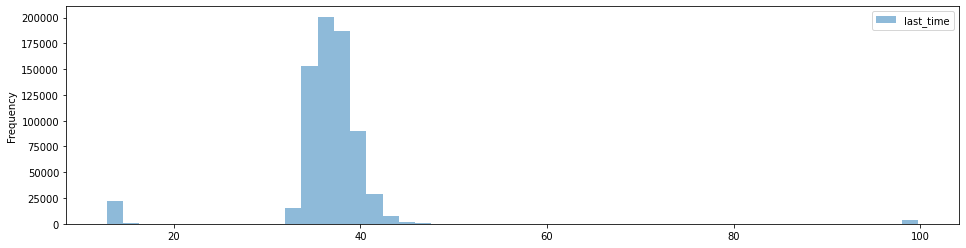

In [65]:
horse_df.plot(kind='hist', y='last_time' , bins=50, figsize=(16,4), alpha=0.5)

In [66]:
horse_df[horse_df['last_time']<20]['race_id'].unique()

array(['200806010208', '200806010304', '200806010604', ...,
       '202207040401', '202209030101', '202209030104'], dtype=object)

In [67]:
race_df[(race_df['race_id']=='200808010804') | (race_df['race_id']=='200806010208') | (race_df['race_id']=='200806010304')]

,race_id,race_round,weather,ground_status,date,where_racecourse,total_horse_number,frame_number_first,horse_number_first,frame_number_second,horse_number_second,frame_number_third,horse_number_third,tansyo,hukusyo_first,hukusyo_second,hukusyo_third,wakuren,umaren,wide_1_2,wide_1_3,wide_2_3,umatan,renhuku3,rentan3,is_obstacle,ground_type,is_left_right_straight,distance,weather_rain,weather_snow
19,200806010208,8,晴,1,2008-01-06 13:40:00,中山,14,6,9,5,7,2,2,2550,510,530,220,970,21030,4010,2050,1870,44390,33660,0,1.0,芝,NaN,3200,0,0
27,200806010304,4,雨,1,2008-01-12 11:20:00,中山,14,3,4,2,2,5,8,2340,330,150,150,2760,3300,880,850,290,8390,2610,0,1.0,芝,NaN,2880,2,0
183,200808010804,4,曇,4,2008-01-27 11:40:00,京都,14,7,12,1,1,8,13,380,130,110,430,350,340,180,1040,920,860,2020,0,1.0,芝,NaN,2930,0,0


### odds

In [68]:
horse_df['odds']= horse_df['odds'].astype(float)

### horse dataの保存

In [69]:
print(horse_df.dtypes)
horse_df.head(3)

race_id                       object
rank                          object
frame_number                   int64
horse_number                   int64
horse_id                      object
age                            int32
burden_weight                float64
rider_id                      object
goal_time                    float64
half_way_rank                float64
last_time                    float64
odds                         float64
popular                      float64
horse_weight                 float64
tamer_id                      object
owner_id                      object
date                  datetime64[ns]
is_down                        int64
is_senba                       int64
is_mesu                        int64
is_osu                         int64
distance                       int32
avg_velocity                 float64
horse_weight_dif             float64
burden_weight_rate           float64
dtype: object


,race_id,rank,frame_number,horse_number,horse_id,age,burden_weight,rider_id,goal_time,half_way_rank,last_time,odds,popular,horse_weight,tamer_id,owner_id,date,is_down,is_senba,is_mesu,is_osu,distance,avg_velocity,horse_weight_dif,burden_weight_rate
0,200806010101,1,1,2,2005102028,3,54.0,733,73.9,1.0,39.2,8.1,4.0,450.0,138,498800,2008-01-05 09:50:00,0,0,1,0,1200,16.238160,-10.0,0.120000
1,200806010101,2,3,5,2005101044,3,54.0,663,73.9,8.5,38.5,13.4,6.0,482.0,1088,163002,2008-01-05 09:50:00,0,0,1,0,1200,16.238160,2.0,0.112033
2,200806010101,3,2,3,2005104156,3,54.0,684,74.2,10.5,38.5,8.2,5.0,458.0,1054,486800,2008-01-05 09:50:00,0,0,1,0,1200,16.172507,4.0,0.117904


In [70]:
horse_df.to_csv("csv/cleaned_horse_data.csv", index=False )